# Deep Learning Analysis of Defect and Phase Evolution During Electron Beam Induced Transformations in WS<sub>2</sub>

Paper can be found at https://arxiv.org/abs/1803.05381

### Authors: Artem Maksov, Maxim Ziatdinov*

*_Correspondence to: ziatdinovmax@gmail.com_

_Date: 05/13/2018_     

In this notebook, we demonstrate a complete workflow for extraction and classification of defects in a STEM image stack (STEM "movie"). 

## Table of Contents 

1. We use a single frame from a movie with FFT subtraction method to create a training dataset. 
2. We train a fully convolutional neural network (without "dense" layers) to find defects that break lattice periodicity.
3. We apply the network to the whole movie and extract subwindows containing individual defects.
4. We train a Gaussian Mixture Model to classify the defects and then we explore their structure and evolution in time.

Requirenments: 
    
1. Python 3 (matplolib, numpy, scipy, sklearn, opencv, h5py)
2. Latest version of pydm3reader: https://microscopies.med.univ-tours.fr/?page_id=260 
3. Keras + tensorflow backend

## 0. Imports 

In [1]:
#%matplotlib nbagg
%matplotlib inline

#I/O
import os
import dm3_lib as dm3
import h5py
from sklearn.externals import joblib

#graphics
import matplotlib
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.gridspec as gridspec
import pylab as P
from matplotlib.patches import Ellipse


#processing 
import numpy as np
from scipy import fftpack
from scipy import ndimage

from skimage.feature import blob_log
from sklearn import cluster, mixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from collections import OrderedDict
from scipy.spatial import cKDTree

C:\Users\artem\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
#neural networks
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Activation, Reshape
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


## 1. Initial image processing 

### 1.1. Reading in the file 

Define path to the file: 

In [3]:
path = './'
filename = 'stack4.dm3'

Read in the image data:

In [4]:
dm3f = dm3.DM3(path + filename)
imgdata = dm3f.imagedata

We need to rescale the image according to gain, and normalize it:

In [5]:
for t in dm3f.tags:
    if 'PMTDF' in t:
        scale = float(dm3f.tags[t])/64000
        
imgdata = imgdata/scale

In [6]:
imgdata = imgdata - np.amin(imgdata)
imgdata = imgdata/np.amax(imgdata)

Create directory for storing outputs:

In [7]:
directory = './Figures/' + filename[:-4] + '/'
if not os.path.exists(directory):
    os.makedirs(directory)

### 1.2 FFT subtraction 

We will explore the first frame of the movie to estimate parameters for FFT subtraction

In [8]:
imgsrc = imgdata[0]

#### 1.2.1 Plotting real space image:

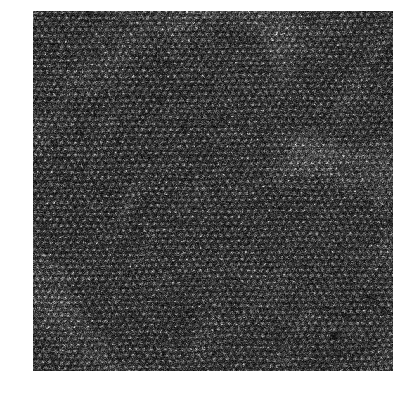

In [9]:
#plot real space image
fig100 = plt.figure(100, figsize=(5,5))
ax = fig100.add_axes([0, 0, 1, 1])
ax.imshow(imgsrc, cmap = 'gray')
ax.axis('off')

#save the figure
fig100.savefig(directory + filename + '_realspace.png')

#### 1.2.2 FFT subtraction

We perform FFT subtraction in a similar manner as to described in (reference)

We need to create a mask and apply it as a high-pass filter in the frequency domain. Currently, this depends on 1 human-defined parameter: 1/ratio of radius of the mask to the image size.

In [10]:
# 1/ratio of the radius of the mask to the original image in pixels
maskratio = 10

In [11]:
def FFTmask(imgsrc, maskratio=10):
    """Takes a square real space image and filter out a disk with radius equal to:
    1/maskratio * image size.
    Retruns FFT transform of the image and the filtered FFT transform
    """
    # Take the fourier transform of the image.
    F1 = fftpack.fft2((imgsrc)) 
    # Now shift so that low spatial frequencies are in the center.
    F2 = (fftpack.fftshift((F1)))
    # copy the array and zero out the center
    F3 = F2.copy()
    l = int(imgsrc.shape[0]/maskratio)
    m = int(imgsrc.shape[0]/2)
    y,x = np.ogrid[1: 2*l + 1, 1:2*l + 1]
    mask = (x - l)*(x - l) + (y - l)*(y - l) <= l*l
    F3[m-l:m+l, m-l:m+l] = F3[m-l:m+l, m-l:m+l] * (1 - mask)
    
    return F2, F3

In [12]:
F2, F3 = FFTmask(imgsrc, maskratio)

We can plot both FFT and filtered FFT to see how it performs:

C:\Users\artem\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


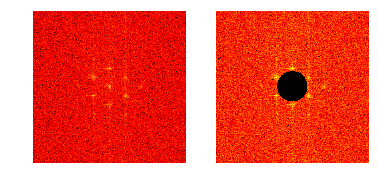

In [13]:
#plot 
fig101 = plt.figure(101)
ax1 = fig101.add_subplot(121)
ax1.imshow(np.abs(np.log(F2)), cmap='hot')
ax1.axis('off')
ax2 = fig101.add_subplot(122)
masked_array = np.ma.array (np.abs(np.log(F3)), mask=np.isnan(np.abs(np.log(F3))))
cm = matplotlib.cm.hot
cm.set_bad('black',1.)
ax2.imshow(masked_array, cm)
ax2.axis('off')

fig101.savefig(directory + 'FFTfilter.png')

Now we reconstruct the real space image from filtered FFT image and subtract it from the original to identify locations with broken symmetry 

In [14]:
def FFTsub(imgsrc, F3):
    """Takes real space image and filtred FFT.
    Reconstructs real space image and subtracts it from the original.
    Returns normalized image. 
    """
    reconstruction = np.real(fftpack.ifft2(fftpack.ifftshift(F3)))
    diff = np.abs(imgsrc - reconstruction)
    
    #normalization
    diff = diff - np.amin(diff)
    diff = diff/np.amax(diff)
    
    return diff

In [15]:
diff = FFTsub(imgsrc, F3)

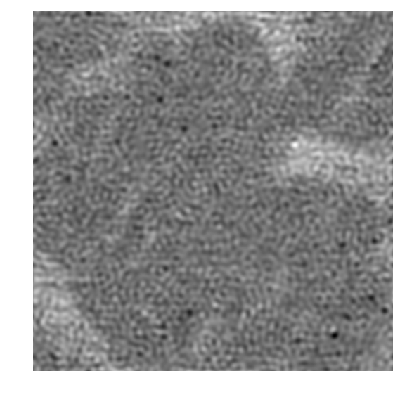

In [16]:
fig102 = plt.figure(102, figsize=(5,5))
ax = fig102.add_axes([0, 0, 1, 1])
ax.imshow(diff, cmap='gray')
ax.axis('off')
fig102.savefig(directory + 'diff.png')

#### 1.2.3 Creating a defect location map

We need to thresold the resulting difference image to create a map for the defect locations, which will serve as labels for pixels in our training set

We need to define 2 thresholds: low for low intensity defects and high for high-intensity. Since we normalized the difference image they are both in [0;1) range

We can use histogram of intensities to inform our choice:

In [17]:
diffall = diff.reshape(diff.shape[0] * diff.shape[1])

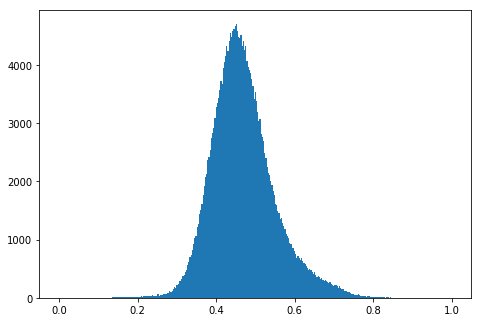

In [18]:
fig103 = plt.figure(103)
ax103 = fig103.add_axes([0, 0, 1, 1])
ax103.hist(diffall, bins='auto');

Or we can inform our choice by computing statistics for the intensity distributions, but those should be taken as guidance and confirmed by visual inspection as they can vary from image to image

In [19]:
print('Defining cutoff as 2 std, low threshold:', np.mean(diffall) - 2* np.std(diffall), 
      ' high thresold: ', np.mean(diffall) + 2* np.std(diffall))
print('Defining cutoff as 3 std, low threshold:', np.mean(diffall) - 3* np.std(diffall), 
      ' high thresold: ', np.mean(diffall) + 3* np.std(diffall))

Defining cutoff as 2 std, low threshold: 0.3071303218603134  high thresold:  0.6319908648729324
Defining cutoff as 3 std, low threshold: 0.22591518610715866  high thresold:  0.7132060006260872


Define the thresholds:

In [20]:
def threshImg(diff, threshL=0.25, threshH=0.75):
    """Takes in difference image, low and high thresold values, and outputs a map of all defects.
    """
    
    threshIL = diff < threshL  
    threshIH = diff > threshH
    threshI = threshIL + threshIH
    
    return threshI

In [21]:
threshL = 0.25
threshH = 0.75

Plot the results:

(-0.5, 511.5, 511.5, -0.5)

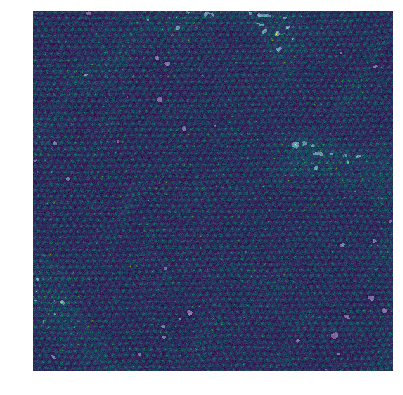

In [22]:
fig104 = plt.figure(104, figsize=(5,5))
ax = fig104.add_axes([0, 0, 1, 1])

threshI = threshImg(diff, threshL, threshH)

ax.imshow(imgsrc)
ax.imshow(threshI, cmap='gray', alpha=0.3)
ax.axis('off')

In [23]:
labelIm = threshI.astype(int)

#### 1.2.4. Generating training set 

We can generate training set by taking patches of the image and corresponding labels

We define helper functions:

In [24]:
#Generate x, y positions for sliding windows
def GenerateXYPos(window_size, window_step, image_width):
    """Takes the window size, step, and total image width 
    and generates all xy pairs for sliding window"""   
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
        
    num_steps = len(xpos_vec)    
            
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))
            
    return pos_mat

In [25]:
def MakeWindow(imgsrc, xpos, ypos, window_size):
    """returns window of given size taken at position on image"""
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

In [26]:
def imgen(raw_image, pos_mat, window_size):
    """Returns all windows from image for given positions array"""
    
    immat = np.zeros(shape = (len(pos_mat), window_size, window_size))
    
    for i in np.arange(0,len(pos_mat)):
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1], window_size) 
        immat[i,:,:,] = img_window
    
    return immat

In [27]:
def image_preprocessing(image_data, norm=0):
    """Reshapes data and optionally normalizes it"""
    image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
    image_data = image_data.astype('float32')
    if norm != 0:
        image_data = (image_data - np.amin(image_data))/(np.amax(image_data) - np.amin(image_data))
    return image_data

In [28]:
def label_preprocessing(image_data, nb_classes):
    """Returns labels / ground truth for images"""
    
    label4D = np.empty((0, image_data.shape[1], image_data.shape[2], nb_classes))
    for idx in range(image_data.shape[0]):
        img = image_data[idx,:,:]
        n, m = img.shape
        img = np.array(OneHotEncoder(n_values=nb_classes).fit_transform(img.reshape(-1,1)).todense())
        img = img.reshape(n, m, nb_classes)
        label4D = np.append(label4D, [img], axis = 0)    
    return label4D

In [29]:
def label_preprocessing2(image_data):
    """we can simplify this in case of only two classes"""
    
    label1 = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
    label2 = -label1 + 1
    label4D = np.concatenate((label2, label1), axis = 3)
    return label4D

We can control the number of patches by changing window size and window step

In [30]:
window_size = 256
window_step = 8
pos_mat = GenerateXYPos(window_size, window_step, imgsrc.shape[0])
print("On image size: ", imgsrc.shape[0], ' by ',  imgsrc.shape[1], ' pixels: ', len(pos_mat), "patches will be generated")

On image size:  512  by  512  pixels:  1024 patches will be generated


In [31]:
immat = imgen(imgsrc, pos_mat, window_size)
labelmat = imgen(labelIm, pos_mat, window_size)

In [32]:
immat2 =  image_preprocessing(immat, 1)
labelmat2 =  label_preprocessing(labelmat, nb_classes = 2)

## 2. Training the Neural Network model

First, we need to define network architecture:

In [33]:
def model_defect(input_img, nb_classes = 2):
    """Creates a Deep Learning model for defect identification"""
    
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
        
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Convolution2D(nb_classes, (3, 3), activation = 'linear', padding='same')(x)
    x = Convolution2D(nb_classes, (1, 1), activation = 'linear', padding='same')(x)

    output = Activation('softmax')(x)
    
    return Model(input_img, output)

We can split data into training and validation set to improve training:

In [34]:
nb_classes = 2
target_size = (256, 256)

X_train, X_test, y_train, y_test = train_test_split(immat2, labelmat2, test_size = 0.2, random_state = 42)

Finally, we train the model:

In [35]:
input_img = Input(shape=(target_size[0], target_size[1], 1)) 

model = model_defect(input_img)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
callback_tb = TensorBoard(log_dir='/tmp/AtomGen', histogram_freq=0,
                          write_graph=True, write_images=False)

In [36]:
model.fit(X_train, y_train, epochs=50, batch_size=32, 
          validation_data=(X_test, y_test), shuffle=True, verbose = 1)

Train on 819 samples, validate on 205 samples
Epoch 1/50
819/819 [==============================] - 11s 14ms/step - loss: 0.2337 - acc: 0.9550 - val_loss: 0.0524 - val_acc: 0.9964
Epoch 2/50
819/819 [==============================] - 5s 6ms/step - loss: 0.0508 - acc: 0.9963 - val_loss: 0.0362 - val_acc: 0.9964
Epoch 3/50
819/819 [==============================] - 6s 7ms/step - loss: 0.0291 - acc: 0.9963 - val_loss: 0.0270 - val_acc: 0.9964
Epoch 4/50
819/819 [==============================] - 6s 7ms/step - loss: 0.0272 - acc: 0.9963 - val_loss: 0.0263 - val_acc: 0.9964
Epoch 5/50
819/819 [==============================] - 6s 7ms/step - loss: 0.0265 - acc: 0.9963 - val_loss: 0.0257 - val_acc: 0.9964
Epoch 6/50
819/819 [==============================] - 6s 7ms/step - loss: 0.0258 - acc: 0.9963 - val_loss: 0.0250 - val_acc: 0.9964
Epoch 7/50
819/819 [==============================] - 6s 7ms/step - loss: 0.0251 - acc: 0.9963 - val_loss: 0.0242 - val_acc: 0.9964
Epoch 8/50
819/819 [========

And save it:

In [37]:
model.save("./DefectModel.h5")
model.save_weights("./DefectModel_weights.h5")
print('Saved model and weights to disk.\n')

Saved model and weights to disk.



## 3. Processing the movie

We can apply the trained model to the rest of the movie to identify defects.

### 3.1 Processing single frame

In [38]:
nframes = imgdata.shape[0]

In [39]:
def splitImage(img, target_size):
    """Splits image into patches with given size"""
    
    xs = img.shape[0]
    ys = img.shape[1]
    nxp = int(xs/target_size[0])
    nyp = int(xs/target_size[1])
    
    impatchmat = np.zeros(shape=(int(nxp*nyp), target_size[0], target_size[1], 1))
    
    count = 0
    for i in range(nxp):
        for i2 in range(nyp):
            xstart = target_size[0] * i
            ystart = target_size[1] * i2
            xend = target_size[0] * (i + 1)
            yend = target_size[1] * (i2 + 1)

            impatchmat[count, :, :, 0] = img[xstart:xend, ystart:yend]
            count = count + 1
            
    return impatchmat

In [40]:
def predictDefects(img, model, target_size, nb_classes=2):
    """Uses given DL model to generate prediciton maps on the image"""
    
    xs = img.shape[0]
    ys = img.shape[1]
    nxp = int(xs/target_size[0])
    nyp = int(xs/target_size[1])
    classpred = np.zeros(shape=(nb_classes,xs, ys))

    impatchmat = splitImage(img, target_size)
    res = model.predict(impatchmat)
    
    count = 0
    for i in range(nxp):
        for i2 in range(nyp):
            xstart = target_size[0] * i
            ystart = target_size[1] * i2
            xend = target_size[0] * (i + 1)
            yend = target_size[1] * (i2 + 1)
            
            for i3 in range(nb_classes):
                classpred[i3, xstart:xend, ystart:yend] = res[count, :, :, i3]
                
            count = count + 1
            
    return classpred

Here is just a test for a single frame:

In [41]:
fnum = 80
classpred = predictDefects(imgdata[fnum], model, target_size, nb_classes)

(-0.5, 511.5, 511.5, -0.5)

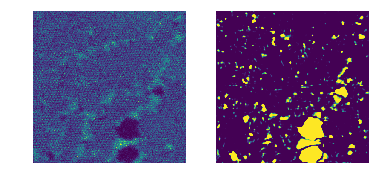

In [42]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(imgdata[fnum])
ax1.axis('off')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred[1])
ax2.axis('off')

(-0.5, 511.5, 511.5, -0.5)

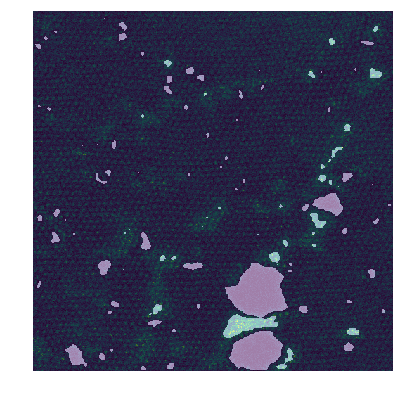

In [43]:
fig301 = plt.figure(301, figsize=(5,5))
ax = fig301.add_axes([0, 0, 1, 1])

ax.imshow(imgdata[fnum])
ax.imshow(classpred[1] > 0.99, cmap='hot', alpha=0.5)
ax.axis('off')

### 3. 2 Defect location identification

To classify the defects, we need to extract image patches containing them. This means we need to filter out defects with large areas, which can be observed in the second half of the movie.

In [44]:
softmax_threhold = 0.5

In [45]:
def extractDefects(img, classpred, softmax_threhold = 0.5, bbox=16):
    
    defim = np.ndarray(shape=(0, bbox*2, bbox*2))
    defcoord = np.ndarray(shape=(0, 2))
    defcount = 0
    
    _, thresh = cv2.threshold(classpred[1], softmax_threhold, 1, cv2.THRESH_BINARY)
    
    s = [[1,1,1],[1,1,1],[1,1,1]]
    labeled, nr_objects = ndimage.label(thresh, structure=s) 
    loc = ndimage.find_objects(labeled)
    cc = ndimage.measurements.center_of_mass(labeled, labeled, range(nr_objects + 1))
    sizes = ndimage.sum(thresh,labeled,range(1, nr_objects +1)) 

    #filter found points
    cc2 = cc[1:]
    t = zip(cc2, sizes)
    ccc = [k[0] for k in t if (k[1] < 700 and k[1] > 5) ]

    max_coord = ccc
    
    
    for point in max_coord:
    
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2

        if startx > 0 and startx < img.shape[0] - bbox*2:
            if starty > 0 and starty < img.shape[1] - bbox*2: 

                defim.resize(defim.shape[0] + 1, bbox*2, bbox*2)
                defim[defcount] = img[startx:endx, starty:endy]
                defcoord.resize(defcoord.shape[0] + 1, 2)
                defcoord[defcount] = point[0:2]

                defcount = defcount + 1
            
    
    return thresh, defim, defcoord

Here is an example of how it works on a single frame:

In [46]:
thresh, defim, defcoord = extractDefects(imgdata[fnum], classpred, softmax_threhold = 0.95, bbox=16)

C:\Users\artem\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


(-0.5, 511.5, 511.5, -0.5)

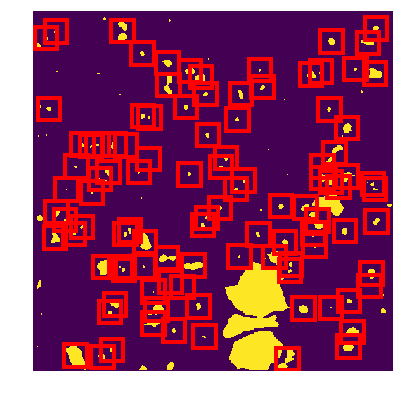

In [47]:
fig302 = plt.figure(302, figsize=(5,5))
ax = fig302.add_axes([0, 0, 1, 1])
ax.imshow(thresh)
bbox = 16

for point in defcoord:
    startx = int(round(point[0] - bbox))
    endx = startx + bbox*2
    starty = int(round( point[1] - bbox))
    endy = starty + bbox*2
    
    p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor='red', lw=4)
    ax.add_patch(p)
    
ax.axis('off')

### 3.3 Applying to the whole movie

Now that we have the functions for the single frames, we can iterate over the movie and extract all the defects for classification

In [48]:
mdirectory = './Figures/' + filename[:-4] + '/Movie/'
if not os.path.exists(mdirectory):
    os.makedirs(mdirectory)

In [49]:
bbox = 16

totdefim = np.zeros(shape=(0, bbox*2, bbox*2))
totdefcoord = np.zeros(shape=(0, 2))
totdeffnum = np.zeros(shape=(0,1))

fig303 = plt.figure(303, figsize=(5,5))
ax = fig303.add_axes([0, 0, 1, 1])


for i, img in enumerate(imgdata):
    #print(i)
    #1. use trained model to predict defecs
    classpred = predictDefects(img, model, target_size, nb_classes=2)
    
    #2. extract defects
    thresh, defim, defcoord = extractDefects(img, classpred, 0.95, bbox)
    
    #3. record the frame
    nd = len(defim)
    deffnum = np.zeros(shape=(nd,1)) + i
    
    #4. append to the array
    totdefim = np.append(totdefim, defim, 0)
    totdefcoord = np.append(totdefcoord, defcoord, 0)
    totdeffnum = np.append(totdeffnum, deffnum, 0)
    
    ax.cla()
    ax.imshow(img)
    for point in defcoord:
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2

        p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor='red', lw=4)
        ax.add_patch(p)
    
    ax.axis('off')
    
    fig303.savefig(mdirectory + '_frame_' + str(i) + '.png')

plt.close(fig303)    

C:\Users\artem\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


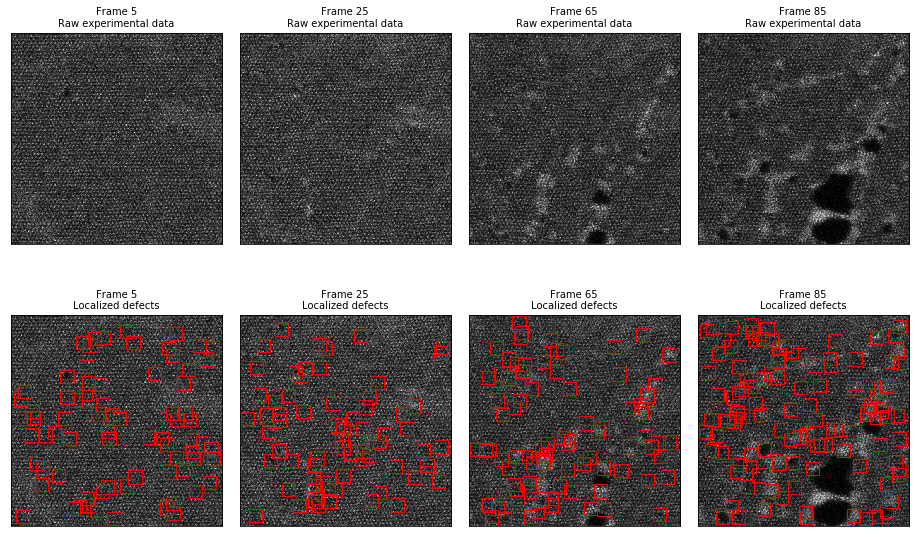

In [50]:
frames = [5, 25, 65, 85]
n = len(frames) + 1

plt.figure(figsize=(16, 8))
for i in range(1, n):
    ax = plt.subplot(2, n, i)
    i_ = frames[i-1]
    plt.imshow(imgdata[i_], cmap = 'gray')
    plt.title('Frame {0}\n'.format(i_) + 'Raw experimental data', fontsize = 10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    ax = plt.subplot(2, n, i + n)
    plt.imshow(imgdata[i_], cmap = 'gray')
    defcoord = totdefcoord[np.where(totdeffnum == i_)[0], :]
    for point in defcoord:
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2
        p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor='red', lw=1)
        ax.add_patch(p)
    plt.title('Frame {0}\n'.format(i_) + 'Localized defects', fontsize = 10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

Because the trained network relies only on the local characteristics of the image, it can identify defects on the later stages of system evolution when the long range periodicity of the lattice is broken due to second phase evolution and displacement and rotation of unreacted WS$_2$ fragments. 

We can now save the data:

In [51]:
np.save('defim.npy', totdefim)
np.save('defcoord.npy', totdefcoord)
np.save('deffnum.npy', totdeffnum)

## 4. Clustering the defects

In [52]:
totdefcoord = np.load('defcoord.npy')
totdeffnum = np.load('deffnum.npy')
totdefim = np.load('defim.npy')
bbox = 16

Now that we extracted the defects we can use gaussain mixture model method to cluster them

### 4.1 Estimating number of clusters

We need to find an estimation of number of different types of defects we can find in the movie. This is not a simple task, as we need to select number of clusters in such a way that it is both representative of most types we are interested in (e.g. not just bright vs dark), but, at the same time, does not start splitting hairs and overwhelming us with unnecessary details.

In [53]:
totdef = totdefim.reshape(totdefim.shape[0], totdefim.shape[1]*totdefim.shape[2])

#### 4.1.1 Dendrogram

Based on tutorial by Jörn Hees: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [54]:
Z = linkage(totdef , 'ward')

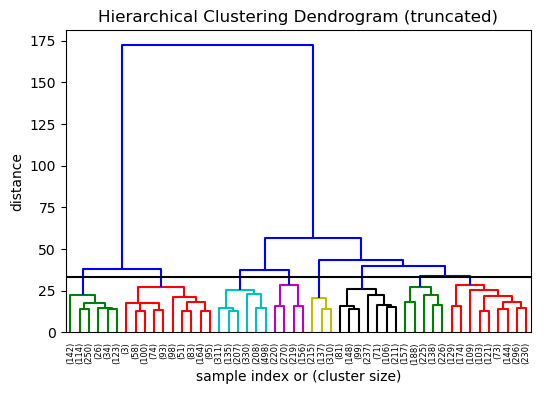

In [57]:
fig400 = plt.figure(400, dpi=100)
max_d = 33
ddata = dendrogram(Z, 
                   truncate_mode='lastp', p=50, 
                   leaf_rotation=90., leaf_font_size=6., 
                   show_contracted=True, color_threshold=max_d)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.axhline(y=max_d, c='k')
plt.show()

Dendrogram is a one way to look at clustering. As distances between clusters become smaller, it makes less sense to plit them. In this example, we can estimate about 5-7 clusters with significant distances. 

#### 4.1.2 PCA

We can use 2 types of estimation from PCA. First, we can use dimensionality reduction method: 

In [58]:
pca = PCA(n_components='mle', svd_solver = 'full')

In [59]:
pca.fit(totdef)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [60]:
pca.n_components_

251

In current run, it results in 250 components with significant contribution to variation. We can look at the Scree plot to find a more reasonable cut off:

[0.03295937 0.02833422 0.02182325 0.01928074 0.01779008 0.01577734
 0.01503136 0.01142846 0.01125425 0.01074092 0.00861317 0.00769002
 0.00710422 0.00644639 0.00579025 0.00514826 0.00493895 0.0048264
 0.00459811 0.00446032 0.00416301 0.00392992 0.00387012 0.00346496
 0.00319295 0.00300315 0.00287723 0.0028034  0.00275502]


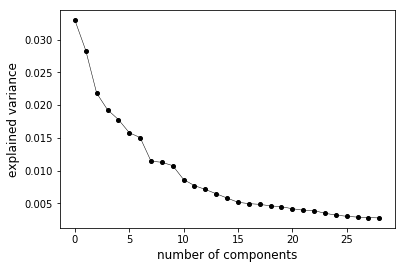

In [61]:
plt.figure()
plt.plot(pca.explained_variance_ratio_[1:30], marker='o',markersize=4, linestyle='-', linewidth = 0.5, color = 'black')
plt.xlabel("number of components", fontsize = 12)
plt.ylabel('explained variance', fontsize = 12)
print(pca.explained_variance_ratio_[1:30]) 

In this case, plot begins to flatten out after about 5-15 components

#### 4.1.3 BIC method

We can use Bayesian Information Criterion: 

In [62]:
totdef2 = totdef - totdef.mean(axis=0)

In [63]:
maxc = 20
bics = list()
for i in range(maxc-1):
    gmm = mixture.GaussianMixture(n_components=i+2, covariance_type='full')
    gmm.fit(totdef2)
    bic = gmm.bic(totdef2)
    bics.append(bic)
    print(i +2, bic)

2 -9427205.86954886
3 -5445834.059790479
4 -1511102.8122140467
5 2196955.2115335986
6 3175674.701396346
7 6716455.323319957
8 8863489.209496167
9 9466834.721120711
10 10311506.085548222
11 14014569.728397816
12 14836720.948965319
13 14043572.257027462
14 17817059.27059704
15 18306403.105679028
16 26024814.558227465
17 26707976.145824537
18 26480662.819514506
19 28123096.081888318
20 33243547.43821366


(array([-20000000., -10000000.,         0.,  10000000.,  20000000.,
         30000000.,  40000000.]), <a list of 7 Text yticklabel objects>)

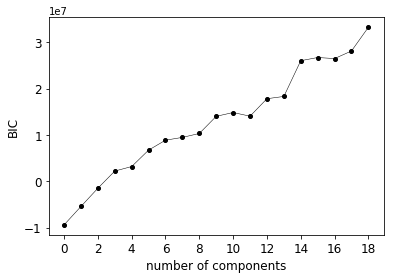

In [64]:
plt.figure()
xt = np.arange(0,20,2)
plt.plot(bics, marker='o',markersize=4, linestyle='-', linewidth = 0.5, color = 'black')
plt.xlabel("number of components", fontsize = 12)
plt.ylabel("BIC", fontsize = 12)
plt.xticks(xt,fontsize = 12)
plt.yticks(fontsize = 12)

In this case, optimal number of clusters is 2. However, we can see some spikes in the graph at in between 5 and 15 clusters.

## 4.2 Identifying types of defects

Although the BIC results were somewhat ambiguous, we can choose the number of clusters we are interested in to be 5. We found it to be an optimal number of components for understanding the type of defect structures present in the data. Indeed, an increase in the number of components resulted in fine (sub-) structures of the detected defects, while decrease in the number of components produced some physically meaningless structures.

In [65]:
nc = 5

#### 4.2.1 Clustering

We will use GMM to identify clusters and then construct an average image for each one:

In [66]:
gmm = mixture.GaussianMixture(n_components=nc, covariance_type='full', random_state=8000)
gmm.fit(totdef)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=8000, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [67]:
clusters = gmm.predict(totdef) + 1

In [68]:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'green', 'darkviolet', 'gold', 'pink', 'red', 'yellow', 'maroon', 'orangered', 'lime', 'darkblue']

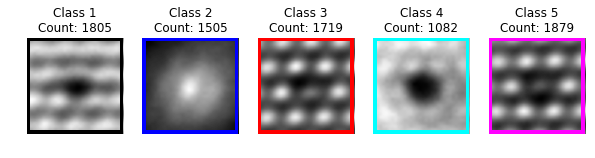

In [71]:
cla = np.ndarray(shape=(np.amax(clusters), 32,32))
fig401 = plt.figure(401, figsize=(10, 5))

rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(np.amax(clusters))/rows))

gs1 = gridspec.GridSpec(rows, cols)

for i in range(np.amax(clusters)):
    cl = totdefim[clusters == i + 1]
    cla[i] = np.mean(cl, axis=0)
    
    ax = fig401.add_subplot(gs1[i])
    ax.imshow(cla[i], cmap = 'gray', Interpolation = 'Gaussian')
    
    ax.axis('off')
    ax.set_title('Class ' + str(i + 1) + '\nCount: ' + str(len(cl)))
    p = patches.Rectangle( (0, 0), bbox*2-1, bbox*2-1,  fill=False, color = colors[i], lw=4)
    ax.add_patch(p)

#plt.subplots_adjust(hspace=0.6, wspace=0.4)
fig401.savefig(directory + 'gmm_nc_' + str(nc) + '.png')

#### 4.2.2 Show clustering on the movie

In [72]:
mdirectory2 = './Figures/' + filename[:-4] + '/MovieClustered_reduced/'
if not os.path.exists(mdirectory2):
    os.makedirs(mdirectory2)

In [74]:
fig403 = plt.figure(403, figsize=(5,5))
ax = fig403.add_axes([0, 0, 1, 1])


for i, img in enumerate(imgdata):
    
    ax.cla()
    ax.imshow(img, cmap ='gray')
    
    
    defcoord = totdefcoord[np.where(totdeffnum == i)[0], :]
    clust = clusters[np.where(totdeffnum == i)[0]]
    
    for i2, point in enumerate(defcoord):
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2

        
        
        p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor=colors[clust[i2] - 1], lw=4)
        ax.add_patch(p)
    
    ax.axis('off')
    fig403.savefig(mdirectory2 + 'frame_' + str(i) + '.png')

plt.close(fig403)

Finally, we should save the data:

In [75]:
#save the clustering data
np.save('clusters.npy', clusters)

### 4.3 Distribution of defects in time

#### 4.3.1 Total counts

We are going to calculate total number of defects and their class distribution in each frame 

To view the trends better, we can use moving average to smooth the curves:

In [76]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [77]:
nframes = imgdata.shape[0]
totclust = np.zeros(shape = (nframes))
totbyclust = np.zeros(shape = (nc, nframes))
totbyclust2 = np.zeros(shape = (nc, nframes))
for i in range(nframes):
    clust = clusters[np.where(totdeffnum == i)[0]]
    totclust[i] = len(clust)
    
    for i2 in range(nc):
        totbyclust[i2, i] = (clust == i2 + 1).sum()    

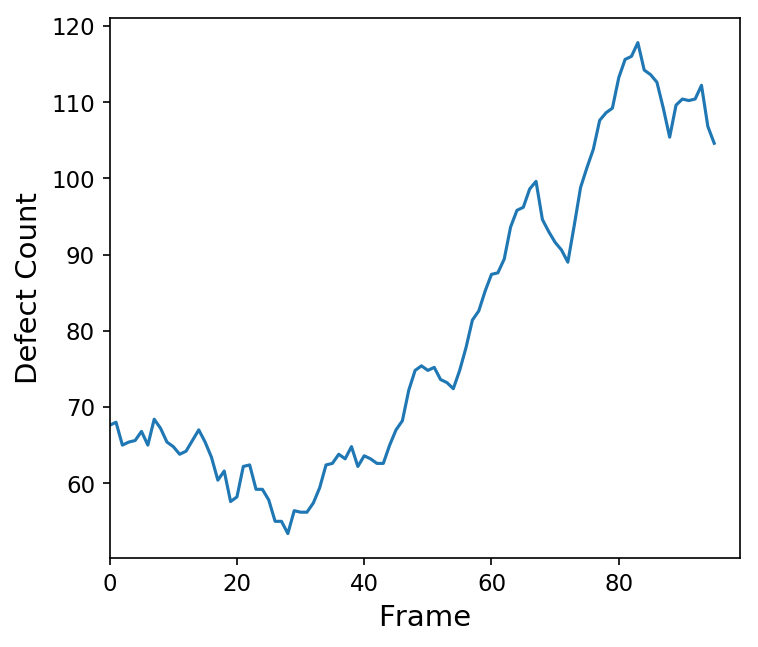

In [78]:
fig430 = plt.figure(430, dpi=150)
ax = fig430.add_axes([0.1, 0.1, 0.7, 0.9])
ax.plot(moving_average(totclust, 5))
ax.set_xlim(0, 99)
ax.set_xlabel('Frame', fontsize = 14)
ax.set_ylabel('Defect Count', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=11)

Here we can observe a significant increase in defects starting at around frame 50. If we look a the movie, this is about when the holes start appearing. Total number of defects peaks at frame 80, due to holes in the material occupying about 25% of the image. 

We can further plot number of defects per cluster per frame:

Text(0,0.5,'Defect Count')

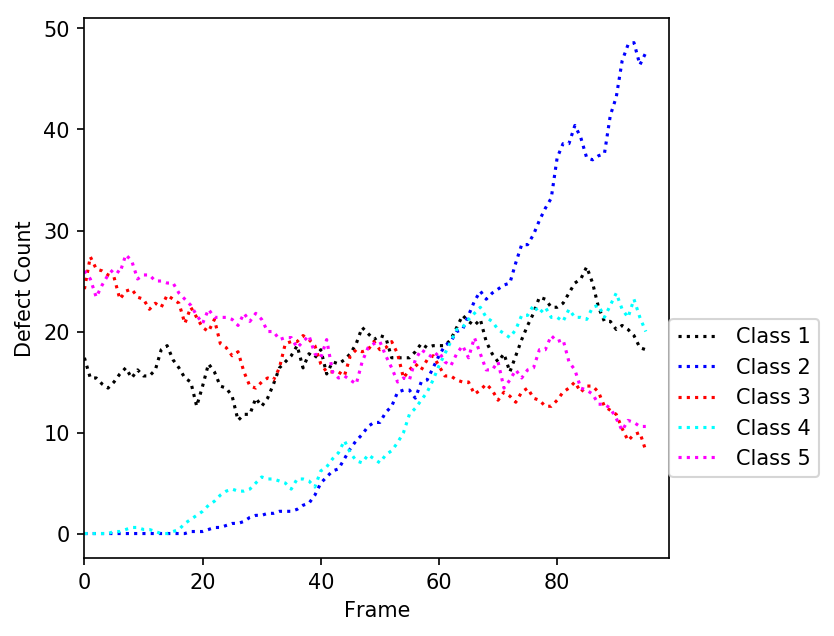

In [79]:
fig431 = plt.figure(431, dpi=150)
ax = fig431.add_axes([0.1, 0.1, 0.65, 0.9])
nc_ = [0, 8, 12]
for i in range(nc):
    ax.plot(moving_average(totbyclust[i], 5), color=colors[i], label=str('Class ' + str(i+1) ), linestyle='dotted')
ax.legend(loc=[1, 0.15], ncol=1)
ax.set_xlim(0, 99)
ax.set_xlabel('Frame')
ax.set_ylabel('Defect Count')

Here we can observe that defects of types 2 and 4 were not identified in the first frame of the movie, which constituted the training set, but were still discovered in later frames.

#### 4.3.2. "Broom" graph

To better understand time evolution of defects, we can construct graphs tracking defects types in (x, y, t) coordinate system

In [80]:
def BroomLines(spo):
    lcin = np.ndarray(shape=(len(spo), 2, 3))
        
    lcin[:, 0, 2] = spo[:, 0]
    lcin[:, 1, 2] = spo[:, 0]
    lcin[:, 0, 1] = spo[:, 1]
    lcin[:, 1, 1] = spo[:, 1]
    lcin[:, 0, 0] = i
    lcin[:, 1, 0] = (i+1) 
    
    return lcin
    

Text(0.5,0,'Frame')

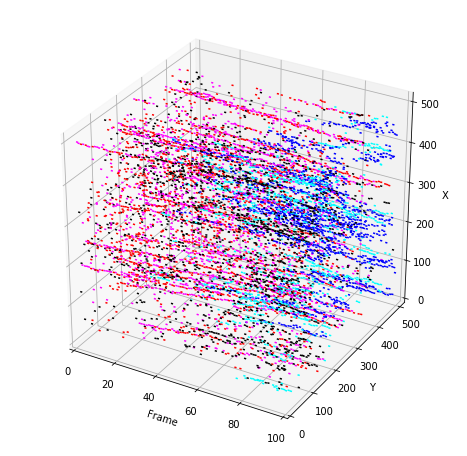

In [81]:
fig432 = plt.figure(432, figsize=(8, 8))
ax = fig432.add_subplot(111, projection='3d')
# We will look into behavior of defects associated with 3 distorted sattes of Mo_w dopant
nc_ = [1, 2, 3, 4, 5]

for i in range(nframes):
    clust = clusters[np.where(totdeffnum == i)[0]]
    coord = totdefcoord[np.where(totdeffnum == i)[0]]

    for c, i2 in enumerate(nc_):
        spo = coord[clust==i2]
        ctest2 = BroomLines(spo)
        lc = Line3DCollection(ctest2, linewidths=1.5, colors=colors[c])    
        ax.add_collection3d(lc)
        
        
ax.set_zlim3d([0, 512])
ax.axis([0, 100, 0, 512])
        
ax.set_zlabel('X')
ax.set_ylabel('Y')
ax.set_xlabel('Frame')

There are three statistical behaviors: weakly moving trajectories, stronger diffusion, and “uncorrelated events”. The most well-defined trajectories are associated with Mo dopants (class 1 and class 3). Interestingly, these Mo defects show different diffusion behaviors depending on their location in the lattice and are characterized by reversible switching between two configurations (class 1 and class 3) along their trajectories. The difference in diffusion behavior may be potentially connected to complex spatial character of strain fields during the material transformation, which may impact diffusion properties

We can further collapse the representation to 2D. In order to show differences in time, we can project windows of defects we found. This allows us to show defects that are continous in time more clearly than randomly occuring ones.

(0, 512)

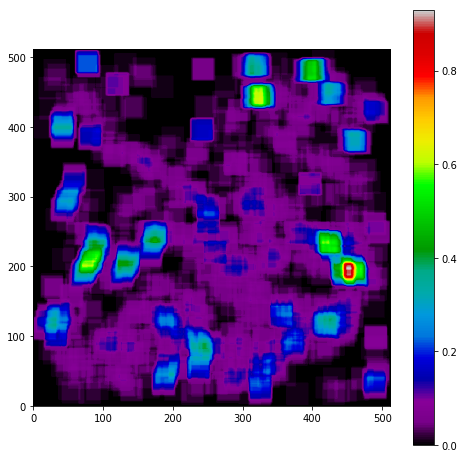

In [82]:
imsum = np.zeros(shape = (imgsrc.shape[0],imgsrc.shape[1]) )

fig435 = plt.figure(435, figsize=(8, 8))
ax = fig435.add_subplot(111)

#list all the clusters for plotting 
cltoplot = [5]

coord = np.empty((0, 2))
for cl in cltoplot:
    coord_ = totdefcoord[np.where(clusters == cl)[0]]
    coord = np.concatenate((coord, coord_))
    for i2, point in enumerate(coord):
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2

        imsum[starty:endy, startx:endx] = imsum[starty:endy, startx:endx] + 1

immean = imsum/imgdata.shape[0]

imsh = ax.imshow(immean, cmap='nipy_spectral', Interpolation = 'Gaussian')
plt.colorbar(imsh)
plt.ylim(0, 512)

We will now isolate selected trajectories for future analysis of diffusion and transition between different states

In [83]:
def rem_coord(co, center, dist_center):
    return [co[0] < center[0] - dist_center, co[0] > center[0] + dist_center,
            co[1] < center[1] - dist_center, co[1] > center[1] + dist_center] 

nc_ = [5]
#selecting projections with highest intensity in the analysis based on projected windows
rois = [(256, 283), (39, 123)]
flow = {}
flow_2d = {}
for i_c, center in enumerate(rois):
    cl_coord = {}
    cl_coord_all_fr = np.empty((0, 2))
    for i in range(nframes):
        clust = clusters[np.where(totdeffnum == i)[0]]
        coord = totdefcoord[np.where(totdeffnum == i)[0]]
        cl_coord_fr = OrderedDict()
        for i2 in nc_:
            spo = coord[clust==i2]
            coord_to_rem = [idx for idx, c in enumerate(spo) if any(rem_coord(c, center, 25))]
            coord_to_rem = np.array(coord_to_rem, dtype = int)
            spo = np.delete(spo, coord_to_rem, axis = 0)
            cl_coord_fr[i2] = spo
            cl_coord_all_fr = np.concatenate((cl_coord_all_fr, spo))          
        cl_coord[i] = cl_coord_fr
    flow_2d[i_c] = cl_coord_all_fr
    flow[i_c] = cl_coord

### Diffusion and switching behaviour for selected trajectories

We will need these functions

In [84]:
def diff_coef(x, y):
    ra = np.var(x)
    rb = np.var(y)
    r = ra + rb
    D = r/(4*len(x)*frame_t)
    return D
    
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

We can now plot 2-d projections of selected "flows" with calculated prediction ellipses. We will also estimate a diffusion coefficient usingn a simple 2-d random walk model.

In [85]:
# confidence interval
nstd = 2
# conversion coefficient (pixels to nanometers) 
px_to_nm = 0.03
# conversion coefficient (frames to time(s))
frame_t = 2.25

Diffusion coefficient for trajectory 0 : 0.0008608657371673503 nm^2/s
Diffusion coefficient for trajectory 1 : 0.0005223416921645357 nm^2/s


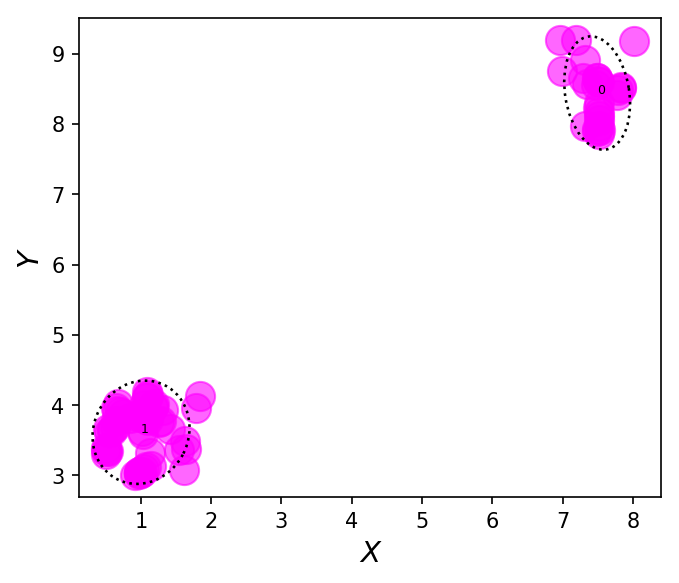

In [88]:
fig436 = plt.figure(436, figsize = (5, 5), dpi = 150)
ax = fig436.add_subplot(111, aspect='equal')
ax.set_xlabel('X', style = 'italic', fontsize = 14)
ax.set_ylabel('Y', style = 'italic', fontsize = 14)
for k_f in range(len(flow_2d.keys())):
    x = flow_2d[k_f][:, 0]*px_to_nm
    y = flow_2d[k_f][:, 1]*px_to_nm
    plt.plot(x, y, 'o', c = 'magenta', markersize = 14, alpha = 0.6, zorder = 1)
    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black', linewidth = 1.25, ls = 'dotted', zorder = 2)
    ell.set_facecolor('none')
    ax.add_artist(ell)
    ax.text(np.mean(x), np.mean(y), str(k_f) , fontsize=6)
    print('Diffusion coefficient for trajectory ' + str(k_f), ':', diff_coef(x, y), 'nm^2/s')    

We can also make a 1-d r(t) representation of the selcted "flows"

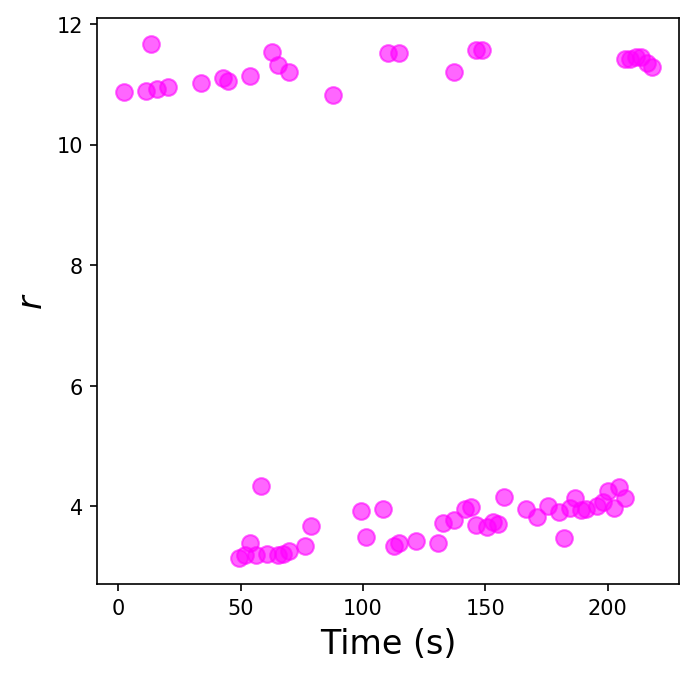

In [89]:
fig = plt.figure(figsize = (5, 5), dpi = 150)
ax = fig.add_subplot(111)
ax.set_xlabel('Time (s)', fontsize = 16)
ax.set_ylabel('r', style = 'italic', fontsize = 16)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
n_frames = 100
for k_f in range(len(flow.keys())):
    spo = flow[k_f]
    for frame in range(n_frames):
        for idx, (k, v) in enumerate(spo[frame].items()):
            if v.shape[0] != 0: 
                v_r = np.sqrt((v[0][0]*px_to_nm)**2 + (v[0][1]*px_to_nm)**2)
                plt.plot(frame*frame_t, v_r, 'o', c=colors[k-1], markersize = 8, alpha = 0.6)  